
# Q-Learning on a Custom FrozenLake Environment
In this notebook, we explore the application of Q-learning to train an agent that navigates a custom 11x11 FrozenLake environment.
We aim to help the agent learn to avoid holes and reach the goal with an optimal policy.



## Environment Setup
- **Custom Map**: A customized 11x11 Frozen Lake map with start (S), holes (H), frozen tiles (F), and goal (G).
- **Environment Initialization**: We set `is_slippery=False` to remove randomness in movements.


In [41]:
#import venv
# Create a virtual environment
#venv.create('env', with_pip=True)
#!env\Scripts\activate


In [42]:
# Activate the virtual environment and install dependencies
!pip install gymnasium gymnasium[toy_text] matplotlib "numpy<2.0"

In [43]:

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from gymnasium.envs.toy_text.frozen_lake import generate_random_map



# Fixed 11x11 custom map
custom_map = [
    "SFFFFFHFFFF",
    "HFFFFFFFFFF",
    "FFFHFFFFFFF",
    "FFFFFFFFFFF",
    "FFFFHFFFFFH",
    "FFFFFFFFHFF",
    "FFFHFFFFFFF",
    "FFFFFHFFFFF",
    "FFFFFFFFFFF",
    "HFFFFFFFFFF",
    "FFFFFFFFFFG"
]


# Create Frozen Lake environment # fro generated map use generate_random_map(size=11)
env = gym.make("FrozenLake-v1", desc=custom_map, is_slippery=False, render_mode="rgb_array")



## Q-Table Initialization
- The Q-table stores learned values for each (state, action) pair.
- Initialized as zeros, representing equal preference for all actions initially.


In [44]:

# Initialize the Q-table
state_space = env.observation_space.n
action_space = env.action_space.n
q_table = np.zeros((state_space, action_space))



## Hyperparameters Setup
- **Alpha**: Learning rate controls how much new knowledge overrides the old.
- **Gamma**: Discount factor for future rewards.
- **Epsilon**: Initial exploration rate for epsilon-greedy strategy.
- **Epsilon Decay**: Reduces exploration over time.
- **Episodes & Steps**: Control the duration of training.


In [45]:

# Hyperparameters
alpha = 0.8  # Learning rate
gamma = 0.95  # Discount factor
epsilon = 1  # Initial exploration rate
epsilon_decay = 0.0001  # Epsilon decay rate
min_epsilon = 0.0001  # Minimum epsilon
episodes = 30000  # Number of episodes for training
max_steps = 300  # Max steps per episode



## Loading or Initializing Q-Table
Load an existing Q-table if available to continue learning, otherwise start fresh.


In [46]:

# Load Q-table if it exists
try:
    q_table = np.load("frozenlake_qtable.npy")
    print("Loaded saved Q-table.")
except FileNotFoundError:
    print("No saved Q-table found. Starting fresh.")


No saved Q-table found. Starting fresh.



## Training Loop
The training loop where the agent learns by interacting with the environment:
- **Epsilon-Greedy**: Chooses between exploration and exploitation.
- **Rewards Structure**: Rewards based on reaching the goal, falling in a hole, or taking steps.
- **Q-Update**: Updates the Q-values based on the observed rewards and future potential rewards.


Episode 500 | Epsilon: 0.9512 | Last Reward: -10 | Won: False
Episode 1000 | Epsilon: 0.9048 | Last Reward: 0 | Won: False
Episode 1500 | Epsilon: 0.8607 | Last Reward: 8 | Won: False
Episode 2000 | Epsilon: 0.8187 | Last Reward: -66 | Won: False
Episode 2500 | Epsilon: 0.7788 | Last Reward: -30 | Won: False
Episode 3000 | Epsilon: 0.7408 | Last Reward: -302 | Won: True
Episode 3500 | Epsilon: 0.7047 | Last Reward: -58 | Won: False
Episode 4000 | Epsilon: 0.6703 | Last Reward: 0 | Won: False
Episode 4500 | Epsilon: 0.6376 | Last Reward: -26 | Won: False
Episode 5000 | Epsilon: 0.6065 | Last Reward: -30 | Won: False
Episode 5500 | Epsilon: 0.5769 | Last Reward: -22 | Won: True
Episode 6000 | Epsilon: 0.5488 | Last Reward: 20 | Won: False
Episode 6500 | Epsilon: 0.5220 | Last Reward: -16 | Won: False
Episode 7000 | Epsilon: 0.4966 | Last Reward: -34 | Won: False
Episode 7500 | Epsilon: 0.4723 | Last Reward: -62 | Won: True
Episode 8000 | Epsilon: 0.4493 | Last Reward: 0 | Won: False
Epis

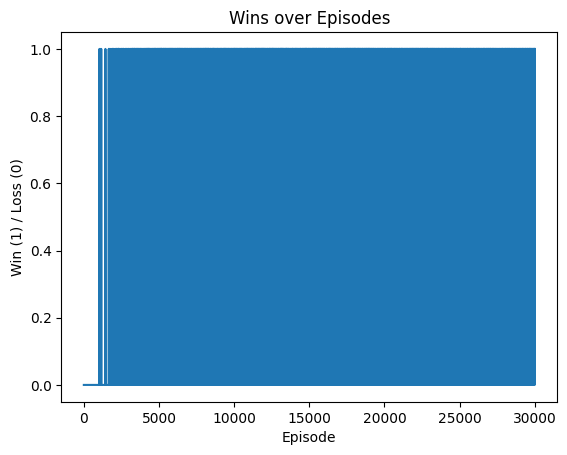

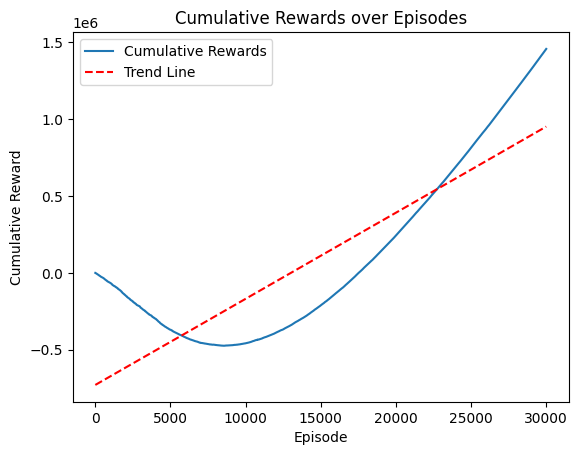

In [47]:
# Training loop
episode_rewards = []
states_visited = []
actions_taken = []
episode_wins = []  # Track if the episode was won

for episode in range(episodes):
    state, _ = env.reset()
    total_rewards = 0
    won = False  # Initialize the win flag for the episode

    for step in range(max_steps):
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state, :])
        
        next_state, reward, done, _, _ = env.step(action)

        goal_state = state_space - 1
        distance_to_goal = abs(state - goal_state)
        next_distance_to_goal = abs(next_state - goal_state)

        if done and reward == 0:
            reward = 0
        elif done and reward == 1:
            reward = 100
            won = True  # Set the win flag if the goal is reached
        else:
            step_penalty = -10
            reward = step_penalty + 2 * (distance_to_goal - next_distance_to_goal)

        q_table[state, action] = q_table[state, action] + alpha * (
            reward + gamma * np.max(q_table[next_state, :]) - q_table[state, action]
        )

        states_visited.append(state)
        actions_taken.append(action)
        state = next_state
        total_rewards += reward

        if done:
            break

    epsilon = max(min_epsilon, epsilon * (1 - epsilon_decay))
    episode_rewards.append(total_rewards)
    episode_wins.append(won)  # Append the win status for the episode

    if (episode + 1) % 500 == 0:
        print(f"Episode {episode + 1} | Epsilon: {epsilon:.4f} | Last Reward: {total_rewards} | Won: {won}")

# Plotting the wins over episodes
plt.plot(episode_wins)
plt.xlabel('Episode')
plt.ylabel('Win (1) / Loss (0)')
plt.title('Wins over Episodes')
plt.show()

# Plotting cumulative rewards with regression line
cumulative_rewards = np.cumsum(episode_rewards)
plt.plot(cumulative_rewards, label='Cumulative Rewards')

# Fit a regression line to the cumulative rewards
z = np.polyfit(range(len(cumulative_rewards)), cumulative_rewards, 1)
p = np.poly1d(z)
plt.plot(p(range(len(cumulative_rewards))), "r--", label='Trend Line')

plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards over Episodes')
plt.legend()
plt.show()


## Saving Q-Table
Saves the trained Q-table to continue learning or for future usage.


In [48]:

# Save the trained Q-table
np.save("frozenlake_qtable.npy", q_table)
print("Trained Q-table saved.")


Trained Q-table saved.



## Testing the Agent
After training, we test the agent to evaluate its performance based on the learned policy.


In [49]:

# Testing the agent
test_episodes = 100
total_rewards = 0

for episode in range(test_episodes):
    state, _ = env.reset()
    for step in range(max_steps):
        action = np.argmax(q_table[state, :])
        next_state, reward, done, _, _ = env.step(action)
        total_rewards += reward
        state = next_state
        if done:
            break

print(f"Average reward over {test_episodes} test episodes: {total_rewards / test_episodes}")


Average reward over 100 test episodes: 1.0



## Visualization of Q-Table and Policy
- **Q-Values Map**: Shows the learned policy in terms of best actions to take in each state.
- **Helper Functions**: Functions to create visualizations of the learned Q-values.


In [50]:
# Helper Functions
output_dir = "output"  # Define the output directory
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

def qtable_directions_map(q_table, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = q_table.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(q_table, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

def plot_q_values_map(q_table, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(q_table, map_size)

    # Capture the last frame of the environment
    env.reset()
    frame = env.render()  # Render mode should be set to 'rgb_array'

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(frame)
    ax[0].axis("off")
    ax[0].set_title("Last Frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    plt.tight_layout()
    
    # Instead of plt.show(), save the figure
    plot_filename = os.path.join(output_dir, "q_values_map.png")
    plt.savefig(plot_filename)
    plt.close()

def plot_states_actions_distribution(states, actions):
    """Plot the distributions of states and actions."""
    labels = {0: "LEFT", 1: "DOWN", 2: "RIGHT", 3: "UP"}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Plot distribution of states
    sns.histplot(data=states, ax=ax[0], kde=True, bins=state_space)
    ax[0].set_title("State Distribution")

    # Plot distribution of actions
    sns.histplot(data=actions, ax=ax[1], bins=4)
    ax[1].set_xticks(list(labels.keys()), labels=labels.values())
    ax[1].set_title("Action Distribution")

    plt.tight_layout()
    
    # Instead of plt.show(), save the figure
    plot_filename = os.path.join(output_dir, "states_actions_distribution.png")
    plt.savefig(plot_filename)
    plt.close()

def plot_success_rate(episode_wins, window_size=100):
    """Plot the success rate over episodes."""
    success_rate = [np.mean(episode_wins[i:i+window_size]) for i in range(0, len(episode_wins), window_size)]
    plt.plot(success_rate)
    plt.xlabel('Episode (in windows of 100)')
    plt.ylabel('Success Rate')
    plt.title('Success Rate over Episodes')
    plt.tight_layout()
    
    # Instead of plt.show(), save the figure
    plot_filename = os.path.join(output_dir, "success_rate_over_episodes.png")
    plt.savefig(plot_filename)
    plt.close()

# Visualize the Q-table and policy
plot_q_values_map(q_table, env, len(custom_map))

# Visualize state and action distributions
plot_states_actions_distribution(states_visited, actions_taken)

# Visualize the Q-table
print("Trained Q-Table:")
print(q_table)

# Plotting the wins over episodes
plt.plot(episode_wins)
plt.xlabel('Episode')
plt.ylabel('Win (1) / Loss (0)')
plt.title('Wins over Episodes')
plt.savefig(os.path.join(output_dir, "wins_over_episodes.png"))
plt.close()

# Plotting the success rate over episodes
plot_success_rate(episode_wins)

Trained Q-Table:
[[ 76.06230476   0.          90.59189975  76.06230476]
 [ 74.06230476 103.7809471   95.75568589  88.59189975]
 [ 86.59189975 109.21651146  87.51068857  93.75568589]
 [ 91.75568589 100.53756691  99.53756691  85.51068857]
 [ 83.51068857 113.19743885 110.34493885  97.53756691]
 [ 95.53696567 124.57361985   0.         108.34103967]
 [  0.           0.           0.           0.        ]
 [  0.         102.78991251   0.          69.65953351]
 [ -0.8448       0.          44.01230869   0.        ]
 [  7.99713507  73.36139588  20.60009207  42.26040091]
 [ 29.3931729   33.06981907  -9.92        18.68433577]
 [  0.           0.           0.           0.        ]
 [  0.          96.61152327  89.21651146  66.59189975]
 [ 79.7809471  102.33316996  80.53756691  71.75568589]
 [ 85.21651146   0.          93.19743885  63.51068857]
 [ 76.53756691 106.52361985 104.57361985  75.53756691]
 [ 89.19743885 118.49854721 113.97416596  86.34493885]
 [100.57282482 128.3938589  110.11287546   0.   